In [213]:
from math import pi, sqrt, cosh, exp, floor, tanh, log, sinh, cosh, erf
import numpy as np
from numpy import linspace, logspace
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.special import legendre

import matplotlib.pyplot as plt
#makes plots bigger and use Latex fonts
from matplotlib import rcParams
rcParams["figure.dpi"]=600
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 2.5

In [199]:
HBARC = 197.3269718
NEUTRON_MASS = 939.5653 / HBARC
PROTON_MASS = 938.272 / HBARC
NUCLEON_MASS = 2 * NEUTRON_MASS * PROTON_MASS / (NEUTRON_MASS + PROTON_MASS)
MUON_MASS = 105.7 / HBARC
ELECTRON_MASS = 0.511 / HBARC
GA = 1.267
MEVFM3_TO_GCM3 = 1.78e12
FM4_TO_DYNECM2 = 3.16e35
G_TO_FM = 7.69**2 / 10**16 / HBARC**2

COS_TC = sqrt(0.95)
GF = (HBARC / 292800)**2
GN = -1.913 * 2
GP = 3.586 + 2

def gntilde(eb, t):
    return GF**2 * COS_TC**2 * eb / (4 * pi * cosh(GN * eb / (4 * NUCLEON_MASS * t)))
def gptilde(eb, t):
    return GF**2 * COS_TC**2 * eb / (4 * pi * cosh(GP * eb / (4 * NUCLEON_MASS * t)))

def gtilde(eb):
    return GF**2 * COS_TC**2 * eb / (32 * pi**4)

#set np_branch to 1 for neutrons and -1 for protons
def e0pm(knu, eb, sn, sp, np_branch):
    return knu + np_branch * (NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS))
def e0pr(knu, eb, sn, sp, np_branch):
    return knu + np_branch * (NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + (GP - 2) * sp * eb / (4 * NUCLEON_MASS))

def v_tilde(x):
    if x > 1: return 2 * x - 2
    else: return 0

def fermi_dirac(x):
    x = np.asarray(x)  # Ensure input is an array if it's not already
    result = np.empty_like(x, dtype=np.float64)
    
    # For x > 0, use the identity: 1 / (exp(x) + 1) = exp(-x) / (1 + exp(-x))
    pos_mask = x > 0
    result[pos_mask] = np.exp(-x[pos_mask]) / (1 + np.exp(-x[pos_mask]))
    
    # For x <= 0, compute directly: 1 / (exp(x) + 1)
    result[~pos_mask] = 1 / (np.exp(x[~pos_mask]) + 1)
    
    return result

def nfd(e, mu, t):
    return fermi_dirac((e - mu) / t)

#if ne is 0, set ne0 to 1
def mat_elt(sp, sn, ct_nu, ne0 = 0):
    if sp == 1 and sn == 1:
        return 2 * (1 + GA)**2 * (1 + ct_nu) + 2 * (1 - GA)**2 * (1 - ct_nu) * (1 - ne0)
    elif sp == 1 and sn == -1:
        return 8 * GA**2 * (1 - ct_nu)
    elif sp == -1 and sn == 1:
        return 8 * GA**2 * (1 + ct_nu) * (1 - ne0)
    elif sp == -1 and sn == -1:
        return 2 * (1 - GA)**2 * (1 + ct_nu) + 2 * (1 + GA)**2 * (1 - ct_nu) * (1 - ne0)
    else:
        print('invalid spin')
        return 0

def opacity_prefactor_noss(sp, sn, eb, knu, ctnu, mue, temperature, np_branch, is_high, continuum = False):
    if is_high:
        e0 = e0pr(knu, eb, sn, sp, np_branch)
        if e0 > ELECTRON_MASS:
            return 8 * pi**3 * gtilde(eb) * fermi_dirac((mue - e0)/ temperature) * mat_elt(sp, sn, ctnu, 1)
        else:
            return 0
    else:
        e0 = e0pm(knu, eb, sn, sp, np_branch)
        print(e0)
        #print((e0**2 - ELECTRON_MASS**2) / (2 * eb))
        if not continuum:
            #if e0 > ELECTRON_MASS:
            #    return 8 * pi**3 * gtilde(eb) * fermi_dirac((mue - e0) / temperature) * (v_tilde((e0**2 - ELECTRON_MASS**2) / (2 * eb)) * mat_elt(sp, sn, ctnu) + mat_elt(sp, sn, ctnu, 1))
            #else:
            return 8 * pi**3 * gtilde(eb) * fermi_dirac(mue / temperature) * mat_elt(sp, sn, ctnu, 1) * (tanh(6 * (e0 - ELECTRON_MASS) / temperature) + 1) / 2
        else:
            if e0 > ELECTRON_MASS:
                return 8 * pi**3 * gtilde(eb) * fermi_dirac((mue - e0) / temperature) * (e0**2 - ELECTRON_MASS**2) / eb * mat_elt(sp, sn, ctnu)
            else:
                return 8 * pi**3 * gtilde(eb) * fermi_dirac((mue - e0) / temperature) * mat_elt(sp, sn, ctnu)
        
def opacity_prefactor_ss(eb, knu, ctnu, mue, temperature, np_branch, is_high):
    result = 0
    for sp in [-1, 1]:
        for sn in [-1, 1]:
            if is_high:
                e0 = e0pr(knu, eb, sn, sp, np_branch)
            else:
                e0 = e0pm(knu, eb, sn, sp, np_branch)
            if e0 > 0:
                result += gtilde(eb) * fermi_dirac((mue - e0) / temperature) * (v_tilde((e0**2 - ELECTRON_MASS**2) / (2 * eb)) * mat_elt(sp, sn, ctnu) + mat_elt(sp, sn, ctnu, 1))
            else:
                result += gtilde(eb) * fermi_dirac((mue - e0) / temperature) * mat_elt(sp, sn, ctnu, 1)
    return result

def maxboltz_prot_pref(prot_dens, eb, temperature):
    ebmt = eb / (NUCLEON_MASS * temperature)
    return prot_dens * tanh(ebmt / 2) / (ebmt * cosh(GP * ebmt / 4))

def maxboltz_neut_pref(neut_dens, eb, temperature):
    ebmt = eb / (NUCLEON_MASS * temperature)
    return neut_dens / (2 * cosh(GN * ebmt / 4))

def s3(r1, r2, d):
    if d > r1 + r2:
        return 0
    elif np.abs(r1 - r2) < d:
        return pi * (r1 + r2 - d)**2 * (d**2 + 2 * d * (r1 + r2) - 3 * (r1 - r2)**2) / (12 * d)
    else:
        return 4 * pi / 3 * min([r1**3, r2**3])

In [211]:
def neutron_opacity(nuc_info, eb, temperature, mue, knu, ctnu, is_high, is_degen, continuum = False):
    if is_degen:
        mun, mup = nuc_info
        kfn = sqrt(2 * NUCLEON_MASS * mun)
        kfp = sqrt(2 * NUCLEON_MASS * mup)
        if is_high:
            print('I have not done this yet')
            return 0
        else:
            return opacity_prefactor_ss(eb, knu, ctnu, mue, temperature, 1, is_high) * (4 * pi * kfn**3 / 3 - s3(kfn, kfp, knu))
    else:
        nb, yp = nuc_info
        nn = nb * (1 - yp)
        np = nb * yp
        ebmt = eb / (NUCLEON_MASS * temperature)
        mt = NUCLEON_MASS * temperature
        result = 0
        for sp in [-1, 1]:
            for sn in [-1, 1]:
                if is_high:
                    spin_weighting = exp((GP * sp - 1) * ebmt / 2) * cosh(ebmt / 2)
                    neutrino_suppression = exp(- (knu * ctnu)**2 / (4 * mt) - (knu**2 * (1 - ctnu**2)) / 2 * (1 - exp(-ebmt)) / (eb + mt * (1 - exp(-ebmt))))
                    blocking_term = 2 * ebmt / (ebmt + 1 - exp(-ebmt)) * (pi / mt)**(3 / 2) * spin_weighting * neutrino_suppression
                else:
                    blocking_term = exp (GP * sp * ebmt / 2) * exp(- knu**2 / (4 * mt))
                result += exp(GN * sn * ebmt / 2) * opacity_prefactor_noss(sp, sn, eb, knu, ctnu, mue, temperature, 1, is_high, continuum) * maxboltz_neut_pref(nn, eb, temperature) * (1 - blocking_term * maxboltz_prot_pref(np, eb, temperature))
        return result

def proton_opacity(nuc_info, eb, temperature, mue, knu, ctnu, is_high, is_degen, continuum = False):
    if is_degen:
        mun, mup = nuc_info
        kfn = sqrt(2 * NUCLEON_MASS * mun)
        if mup > 0:
            kfp = sqrt(2 * NUCLEON_MASS * mup)
        else:
            kfp = 0
        if mup < 0 or kfp + knu < kfn:
            mt = NUCLEON_MASS * temperature
            kfnt = kfn / sqrt(2 * mt)
            knut = knu / sqrt(2 * mt)
            if not is_high:
                prefactor = exp(mup / temperature) / 4 * (mt / (2 * pi))**(3 / 2)
                nucleon_term = prefactor * (2 * sinh(2 * knut * kfnt) * exp(-knut**2 - kfnt**2) + sqrt(pi) * knut * (1 + erf(kfnt + knut) - erf(kfnt - knut)))
            else:
                u = mt / eb * (1 - exp(-eb / mt))
                prefactor = exp(mup / temperature) * kfn**3 / (8 * pi**2)
                first_term = 1 / kfnt**3 * (1.978 + (2 * u - 1) * (-0.498) + (kfnt - 2) * (-0.768) + legendre(2)(2 * u - 1) * (0.110) + legendre(2)(kfnt - 2) * (0.174))
                second_term = knut / kfnt**8 * (2 * sqrt(pi) * (3 + 2 * u) * exp(-u) * erf(kfnt * sqrt(1 - u)) / (kfnt * sqrt(1 - u)) - 4 * exp(-kfnt**2))
                nucleon_term = prefactor * (first_term + second_term)
            return opacity_prefactor_ss(eb, knu, ctnu, -mue, temperature, -1, is_high) * nucleon_term
        elif is_high:
            print('I have not done this yet')
            return 0
        else:
            return opacity_prefactor_ss(eb, knu, ctnu, -mue, -1, is_high) * (4 * pi * kfp**3 / 3 - s3(kfn, kfp, knu))
    else:
        nb, yp = nuc_info
        nn = nb * (1 - yp)
        np = nb * yp
        ebmt = eb / (NUCLEON_MASS * temperature)
        mt = NUCLEON_MASS * temperature
        result = 0
        for sp in [-1, 1]:
            for sn in [-1, 1]:
                if is_high:
                    blocking_term = exp(GN * sn * ebmt / 2) / (ebmt + 1 - exp(-ebmt)) * exp(- (knu * ctnu)**2 / (4 * mt) - (knu**2 * (1 - ctnu**2)) / 2 * (1 - exp(-ebmt)) / (eb + mt * (1 - exp(-ebmt))))
                    result += opacity_prefactor_noss(sp, sn, eb, knu, ctnu, -mue, temperature, -1, is_high, continuum) * exp((GP * sp - 1) * ebmt / 2) * cosh(ebmt / 2) * maxboltz_prot_pref(np, eb, temperature) * (ebmt / (1 - exp(-ebmt)) 
                        - blocking_term * maxboltz_neut_pref(nn, eb, temperature))
                else:
                    blocking_term = exp(GN * sn * ebmt / 2) * exp(- knu**2 / (4 * mt))
                    result += opacity_prefactor_noss(sp, sn, eb, knu, ctnu, -mue, temperature, -1, is_high, continuum) * exp(GP * sp * ebmt / 2) * maxboltz_prot_pref(np, eb, temperature) * (ebmt / (1 - exp(-ebmt)) 
                        - blocking_term * maxboltz_neut_pref(nn, eb, temperature))
        return result
                
                #result += gptilde(eb, t) * prot_density * sinh(ebmt / 2) / ebmt * mat_elt(sp, sn, ct_nu, ne0) * v_tilde * exp(GP * sp * ebmt / 2) * (
                #    1 - neut_density * exp(GN * sn * ebmt / 2) * (pi / mt)**(3 / 2) / (2 * cosh(GP * ebmt / 4)) * exp(- knu**2 / (4 * mt)))


In [20]:
def electron_energy(eb, n, kz):
    return np.sqrt(2 * n * eb + kz**2 + ELECTRON_MASS**2)

def log_electron_density(mu, eb, t):
    if mu < 0:
        max_ll = 10 * floor(t**2 / (2 * eb))
    else:
        max_ll = 10 * floor((t + mu)**2 / (2 * eb))

    #print(max_ll)
    pos_ll = linspace(1, max_ll, max_ll)
    return log(quad(lambda kz: eb / (2 * pi**2) * (nfd(np.sqrt(kz**2 + ELECTRON_MASS**2), mu, t) + 2 * np.sum(nfd(electron_energy(eb, pos_ll, kz), mu, t))), 0, max((20 * t, 20 * (t + mu), 50 * sqrt(t * 2 * eb))))[0])

#this determines the electron chemical potential from the electron density
def mue_solver(ne, eb, t):
    return fsolve(lambda mu: log(ne) - log_electron_density(mu, eb, t), 5 / HBARC)[0]

def mue_solver_zero(ne, t):
    return fsolve(lambda mu: log(ne) - log(quad(lambda k: k**2 / (pi**2 * (np.exp((k - mu) / t) + 1)), 0, max((20 * t, 20 * (t + mu))))[0]), 20 / HBARC)[0]

In [208]:
def nun_opacity_high(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))
    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + (GP - 2) * sp * eb / (4 * NUCLEON_MASS)
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu, 1) * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density * exp((GP * sp - 1) * ebmt / 2) * (pi / mt)**(3 / 2) * sinh(ebmt / 2) / cosh(GP * ebmt / 4) * 2 / (ebmt + 1 - exp(-ebmt))
                * exp(- knu**2 * (1 - ct_nu**2) / (2 * eb + 2 * mt) * eb * exp(-ebmt) / (eb + mt * (1 - exp(-ebmt))) - knu**2 * ct_nu**2 / (4 * mt)))
    return result

def nun_opacity_med(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS)
            v_tilde = max((e0pl**2 / eb, 1))
            if v_tilde == 1:
                ne0 = 1
            else:
                ne0 = 0
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu, ne0) * v_tilde * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density * exp(GP * sp * ebmt / 2) * (pi / mt)**(3 / 2) * sinh(ebmt / 2) / cosh(GP * ebmt / 4) / ebmt * exp(- knu**2 / (4 * mt)))
    return result

def nun_opacity_low(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS)
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu) * e0pl**2 / eb * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density / 2 * exp(GP * sp * ebmt / 2) * (pi / mt)**(3 / 2) / cosh(GP * ebmt / 4) * exp(- knu**2 / (4 * mt)))
    return result

def nun_opacity_zero(nb, yp, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver_zero(prot_density, t)
    #print(mue)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS
            result += GF**2 * COS_TC**2 / (4 * pi) * neut_density / 2 * mat_elt(sp, sn, ct_nu) * e0pl**2 * (1 - nfd(e0pl, mue, t)) * (
                1 - prot_density / 2 * (pi / mt)**(3 / 2) * exp(- knu**2 / (4 * mt)))
    return result

def nup_opacity_high(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            result += gptilde(eb, t) * prot_density * sinh(ebmt / 2) * mat_elt(sp, sn, ct_nu, 1) * exp((GP * sp - 1) * ebmt / 2) * (
                1 / (1 - exp(- ebmt)) - neut_density * exp(GN * sp * ebmt / 2) * (pi / mt)**(3 / 2) / cosh(GN * ebmt / 4) / (ebmt + 1 - exp(-ebmt))
                * exp(- knu**2 * (1 - ct_nu**2) / 2 * (1 - exp(-ebmt)) / (eb + mt * (1 - exp(-ebmt))) - knu**2 * ct_nu**2 / (4 * mt)))
    return result

def nup_opacity_med(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0min = knu - (NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS))
            if e0min > 0:
                v_tilde = max((e0min**2 / eb, 1))
                if v_tilde == 1:
                    ne0 = 1
                else:
                    ne0 = 0
                result += gptilde(eb, t) * prot_density * sinh(ebmt / 2) / ebmt * mat_elt(sp, sn, ct_nu, ne0) * v_tilde * exp(GP * sp * ebmt / 2) * (
                    1 - neut_density * exp(GN * sn * ebmt / 2) * (pi / mt)**(3 / 2) / (2 * cosh(GP * ebmt / 4)) * exp(- knu**2 / (4 * mt)))
    return result

def nup_opacity_low(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0min = knu - (NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS))
            if e0min > 0:
                result += gptilde(eb, t) * prot_density / 2 * mat_elt(sp, sn, ct_nu) * e0min**2 / eb * exp(GN * sn * ebmt / 2) * (
                    1 - neut_density / 2 * exp(GN * sn * ebmt / 2) * (pi / mt)**(3 / 2) / cosh(GN * ebmt / 4) * exp(- knu**2 / (4 * mt)))
    return result

def nup_opacity_zero(nb, yp, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver_zero(prot_density, t)
    #print(mue)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0min = knu - (NEUTRON_MASS - PROTON_MASS)
            if e0min > 0:
                result += GF**2 * COS_TC**2 / (4 * pi) * prot_density / 2 * mat_elt(sp, sn, ct_nu) * e0min**2 * (
                    1 - prot_density / 2 * (pi / mt)**(3 / 2) * exp(- knu**2 / (4 * mt)))
    return result

In [7]:
kappan_comp_3mev = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([9.620698697053828e-42, 1.1679678066802725e-41, 1.2012741599635759e-41, 1.3762456349338368e-41, 1.5000733746970754e-41, 1.7239685458034566e-41, 1.811199445888541e-41, 1.9513174594283932e-41, 2.0506244910408358e-41, 2.138887119920586e-41, 2.2082755999503886e-41, 2.2906394089828734e-41, 2.352956461329258e-41, 2.417830484581144e-41, 2.4922763529919566e-41, 2.607318942363941e-41, 2.828514219132879e-41, 3.299564719726727e-41, 4.2876624058213587e-41, 6.118260617120438e-41])
kappan_comp_1mev = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([7.778990987420739e-45, 3.687426376279251e-44, 1.7570246587074735e-43, 8.058481616902194e-43, 3.247322444995863e-42, 9.648957639008996e-42, 1.8277940635281547e-41, 2.389554329931399e-41, 2.5940367447684583e-41, 2.654844550153016e-41, 2.6674640290705736e-41, 2.667228300794447e-41, 2.6609023397776513e-41, 2.6629424016380714e-41, 2.3720659097910184e-41, 2.2589052802796264e-41, 2.6278444072160873e-41, 2.6488247334664534e-41, 2.662110563180715e-41, 1.7550906787180635e-41])

In [118]:
sigma_n_b1e17_t1mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([7.778990987420739e-45, 3.687426376279251e-44, 1.7570246587074735e-43, 8.058481616902194e-43, 3.247322444995863e-42, 9.648957639008996e-42, 1.8277940635281547e-41, 2.389554329931399e-41, 2.5940367447684583e-41, 2.654844550153016e-41, 2.6674640290705736e-41, 2.667228300794447e-41, 2.6609023397776513e-41, 2.6629424016380714e-41, 2.3720659097910184e-41, 2.2589052802796264e-41, 2.6278444072160873e-41, 2.6488247334664534e-41, 2.662110563180715e-41, 1.7550906787180635e-41])
sigma_n_b1e17_t3mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([9.620698697053828e-42, 1.1679678066802725e-41, 1.2012741599635759e-41, 1.3762456349338368e-41, 1.5000733746970754e-41, 1.7239685458034566e-41, 1.811199445888541e-41, 1.9513174594283932e-41, 2.0506244910408358e-41, 2.138887119920586e-41, 2.2082755999503886e-41, 2.2906394089828734e-41, 2.352956461329258e-41, 2.417830484581144e-41, 2.4922763529919566e-41, 2.607318942363941e-41, 2.828514219132879e-41, 3.299564719726727e-41, 4.2876624058213587e-41, 6.118260617120438e-41])
sigma_n_b5e16_t1mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([1.17401938137146e-49, 5.491588481600998e-49, 2.642562571511133e-48, 1.2066453510674123e-47, 6.236753740064626e-47, 3.0327097032049048e-46, 1.463060675304993e-45, 7.157653141779803e-45, 3.466208010835833e-44, 1.650118033886566e-43, 7.354947009106503e-43, 2.6672687244261273e-42, 6.518887232484027e-42, 1.0937517434398563e-41, 3.326050335859277e-41, 1.2846849625436895e-40, 8.826069434676357e-41, 6.81718032057763e-41, 5.951172697131834e-41, 5.565515987568502e-41])
sigma_n_b5e16_t3mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([6.252927573682462e-44, 9.264479862790461e-44, 1.682266166257047e-43, 2.9307533019164284e-43, 4.879502631743155e-43, 8.016083691020196e-43, 1.2996584434942008e-42, 2.046035011453203e-42, 2.7438359511194488e-42, 4.454117146488285e-42, 6.04525595521001e-42, 7.74683415754672e-42, 9.87107873327385e-42, 1.6139175507328183e-41, 3.970168130465997e-41, 9.527825745903223e-41, 8.399450041635963e-41, 6.7630148100465e-41, 6.186812703505126e-41, 6.306920260803633e-41])

sigma_n_b1e17_t1mev_highdensity = 10**39 * 0.16 * 0.1 * 0.9 * np.array([1.0059687375502003e-70, 4.99544977891665e-70, 2.500170531992311e-69, 1.2586097350279782e-68, 6.372687074316233e-68, 3.243961203667399e-67, 1.659841503855992e-66, 8.534204105064928e-66, 4.40861053948641e-65, 2.2873734455783927e-64, 1.191615292132507e-63, 6.231699505070043e-63, 3.2848249234151976e-62, 1.7600978545110953e-61, 1.0080938214524938e-60, 6.917603120213183e-60, 5.781952840578004e-59, 4.635012383787073e-58, 2.9650191709690163e-57, 1.530880151595223e-56])
sigma_n_b1e17_t3mev_highdensity = 10**39 * 0.16 * 0.1 * 0.9 * np.array([6.101665441851601e-45, 7.983115860502326e-45, 9.95789658938788e-45, 1.1480800286553228e-44, 1.2717820123778925e-44, 1.5035877857537177e-44, 1.8647401085994288e-44, 2.4087209779444106e-44, 3.1817045377943683e-44, 3.972274016584005e-44, 4.765230920940967e-44, 5.977232413644278e-44, 7.526028513030335e-44, 9.611467679913813e-44, 1.2399071471888273e-43, 1.6715507962712868e-43, 2.3797241678073546e-43, 3.671629442057148e-43, 6.033691956045387e-43, 9.816166964341152e-43])
sigma_n_b5e16_t1mev_highdensity = 10**39 * 0.16 * 0.1 * 0.9 * np.array([1.40793787333963e-71, 6.718828291216952e-71, 3.40245166083886e-70, 1.7461184438596708e-69, 9.014606638545846e-69, 4.639184814238914e-68, 2.4041244249592815e-67, 1.2530833706436624e-66, 6.573945416732794e-66, 3.4952152450971567e-65, 2.0107584025591966e-64, 1.5490429700758739e-63, 1.5603631113606208e-62, 1.165589094429525e-61, 5.931769617034605e-61, 2.8452392032249764e-60, 1.4503903570712184e-59, 9.497685029914402e-59, 7.464674495126731e-58, 4.682005564606824e-57])
sigma_n_b5e16_t3mev_highdensity = 10**39 * 0.16 * 0.1 * 0.9 * np.array([1.2133000830551468e-51, 2.0766502779452003e-51, 3.1795041441988117e-51, 4.846033255796863e-51, 8.444890909503878e-51, 1.6049269016180275e-50, 2.883963319386222e-50, 5.116280182477121e-50, 8.84791904615195e-50, 1.5337758892462709e-49, 2.706511470797402e-49, 5.28388490116109e-49, 1.3701878719281036e-48, 4.127942939310412e-48, 9.934747674982951e-48, 2.1222056247998924e-47, 3.2418886291500395e-47, 5.2683107922722805e-47, 1.0371409523360986e-46, 2.245800789631978e-46])

sigma_p_b1e17_t1mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.25 * np.array([6.12125799479412e-44, 2.435672480489152e-42, 3.521160247540954e-41, 4.0575786794812754e-41, 3.9760148867713077e-41, 3.867361016457994e-41, 3.7723844460531513e-41, 3.6392943840085946e-41, 3.6087191100996366e-41, 3.539598795974697e-41, 3.473604096288451e-41, 3.4170321166074697e-41, 3.3585274595659607e-41, 3.313355648679521e-41, 3.267051794561961e-41, 3.2225282062185905e-41, 3.183731440947563e-41, 3.144704045111338e-41, 3.101325066230057e-41, 2.7856337302672723e-41])
sigma_p_b1e17_t3mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.25 * np.array([1.9284824072026427e-42, 5.050848119765926e-42, 1.102204004841579e-41, 1.7260943699509541e-41, 2.1206959905384611e-41, 2.2280626962064193e-41, 2.2928461371171822e-41, 2.333239306614417e-41, 2.3636907521866234e-41, 2.374282666551745e-41, 2.392020072031399e-41, 2.397345548919221e-41, 2.3951464148275055e-41, 2.391522256795314e-41, 2.36198470815759e-41, 2.336169929483668e-41, 2.301230467817195e-41, 2.316454912869878e-41, 2.5249614944373656e-41, 2.9671750675218864e-41])
sigma_p_b5e16_t1mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.25 * np.array([1.422191349080364e-44, 1.6916021907721478e-42, 1.7715123355833212e-41, 1.6821028744133365e-41, 1.6112738037895578e-41, 1.5618453555154654e-41, 1.5187842869827427e-41, 1.4823591941656717e-41, 1.4481896553779022e-41, 1.3623790381369075e-41, 1.2128739652778755e-41, 9.993989770422542e-42, 9.493008662186523e-42, 1.3145227653969907e-41, 1.304251575561053e-41, 1.3636636603181274e-41, 6.007901468883005e-41, 9.213252645573448e-41, 7.146528729382491e-41, 5.519819205365023e-41])
sigma_p_b5e16_t3mev_lowdensity = 10**39 * 0.16 * 10**-3 * 0.25 * np.array([2.7582369215045684e-43, 3.054272100755523e-42, 1.2406367158678737e-41, 1.4776561076089672e-41, 1.438494297978718e-41, 1.4035956640550818e-41, 1.372697981535109e-41, 1.3348952701816678e-41, 1.2744581404342631e-41, 1.2014623812740312e-41, 1.265665894026569e-41, 1.247915003847143e-41, 1.2292743338238174e-41, 1.153826357878878e-41, 1.1704586523307516e-41, 1.725121620640308e-41, 6.341890364106868e-41, 7.314678356546592e-41, 6.52604446433225e-41, 5.351325011497085e-41])

sigma_p_b1e17_t1mev_highdensity = 10**39 * 0.16 * 0.1 * 0.1 * np.array([2.0917877514476344e-46, 2.649576150609127e-45, 1.727006831185111e-44, 5.576127269051677e-44, 9.830459122675274e-44, 1.3221879292440748e-43, 1.5009499485915892e-43, 1.5680424883272221e-43, 1.6020723982010912e-43, 1.6377736793054366e-43, 1.68172231536733e-43, 1.7299519273152707e-43, 1.7939902123797375e-43, 1.8733689620222456e-43, 1.9616173193975197e-43, 2.0627209161694442e-43, 2.175118902289544e-43, 2.3000186401300448e-43, 2.4392760860739855e-43, 2.594547572798194e-43])
sigma_p_b1e17_t3mev_highdensity = 10**39 * 0.16 * 0.1 * 0.1 * np.array([1.9174532563015224e-42, 4.51871765997183e-42, 8.363472632929053e-42, 1.3225465270580082e-41, 1.641348417392358e-41, 1.8080773465094022e-41, 1.8140424429603457e-41, 1.8004140669576178e-41, 1.782301987151538e-41, 1.761385980580708e-41, 1.7401233058119025e-41, 1.7142026227922632e-41, 1.6790832357328236e-41, 1.6696652825688423e-41, 1.6698155079976116e-41, 1.664832012626019e-41, 1.6695218974915754e-41, 1.70967391321879e-41, 1.8166627471149678e-41, 2.135293370912181e-41])
sigma_p_b5e16_t1mev_highdensity = 10**39 * 0.16 * 0.1 * 0.1 * np.array([9.065127196586383e-47, 1.8321949429418875e-45, 1.1916556122443038e-44, 2.367411745647464e-44, 2.825658237848164e-44, 2.928810807601763e-44, 2.9624829356592415e-44, 3.0358256610537855e-44, 3.127675579001835e-44, 3.233409852892241e-44, 3.21374626668436e-44, 3.2840916759860137e-44, 3.3882174546548607e-44, 3.872456895955797e-44, 4.248544587351537e-44, 4.777659800531141e-44, 6.936416121243183e-44, 1.1183729878716436e-43, 2.1757603450686677e-43, 2.8091573827866764e-43])
sigma_p_b5e16_t3mev_highdensity = 10**39 * 0.16 * 0.1 * 0.1 * np.array([1.0020689046819058e-43, 5.972467248987919e-43, 1.7352116092380865e-42, 2.5620302260379443e-42, 2.661578938396437e-42, 2.6318616426316732e-42, 2.5980298297491108e-42, 2.5286543875058278e-42, 2.510259685531352e-42, 2.535682138373055e-42, 2.5251394417675544e-42, 2.4996589691711552e-42, 2.387556699631212e-42, 2.3257610622236383e-42, 2.4577010094884008e-42, 4.4538883148768445e-42, 9.859632478350451e-42, 1.2490502959056733e-41, 1.4498252610941828e-41, 1.3445430124973537e-41])


In [131]:
1e17 * G_TO_FM * 2

0.03037454442452596

In [ ]:
1e17 * G_TO_FM

In [ ]:
(25 + 1.3 + GP * )**2

0.016051185540920623

In [175]:

ebmt = 1e17 * G_TO_FM / (NUCLEON_MASS * 8 / HBARC)
print(ebmt)

0.0787290358570619


In [182]:
2/(1+exp(-0.0787))

1.0393297024298014

C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_ll = 10 * floor((t + mu)**2 / (2 * eb))
C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(lambda mu: log(ne) - log_electron_density(mu, eb, t), 5 / HBARC)[0]
C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:19: RuntimeWarning: overflow encountered in exp
  return fsolve(lambda mu: log(ne) - log(quad(lambda k: k**2 / (pi**2 * (np.exp((k - mu) / t) + 1)), 0, max((20 * t, 20 * (t + mu))))[0]), 20 / HBARC)[0]
C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:19: RuntimeWarning: overflow encountered in multiply


0.006023988307986127
-8.196443514756763e-05
-0.0028907665334003928
-0.008996719276534088
0.008506142237068755
0.002400189493935061
-0.00040861260431776427
-0.006514565347451459
0.010988296166151384
0.004882343423017689
0.0020735413247648642
-0.0040324114183688305
0.01347045009523401
0.007364497352100315
0.00455569525384749
-0.0015502574892862046
0.01595260402431664
0.009846651281182945
0.0070378491829301195
0.0009318964397964247
0.018434757953399265
0.012328805210265572
0.009520003112012747
0.0034140503688790524
0.020916911882481896
0.0148109591393482
0.012002157041095375
0.00589620429796168
0.023399065811564528
0.01729311306843083
0.014484310970178006
0.008378358227044311
0.02588121974064715
0.019775266997513453
0.016966464899260632
0.010860512156126935
0.028363373669729776
0.022257420926596085
0.019448618828343256
0.013342666085209563
0.030845527598812407
0.024739574855678716
0.021930772757425887
0.015824820014292196
0.03332768152789504
0.02722172878476134
0.024412926686508518
0.0183

(0.0, 25.0)

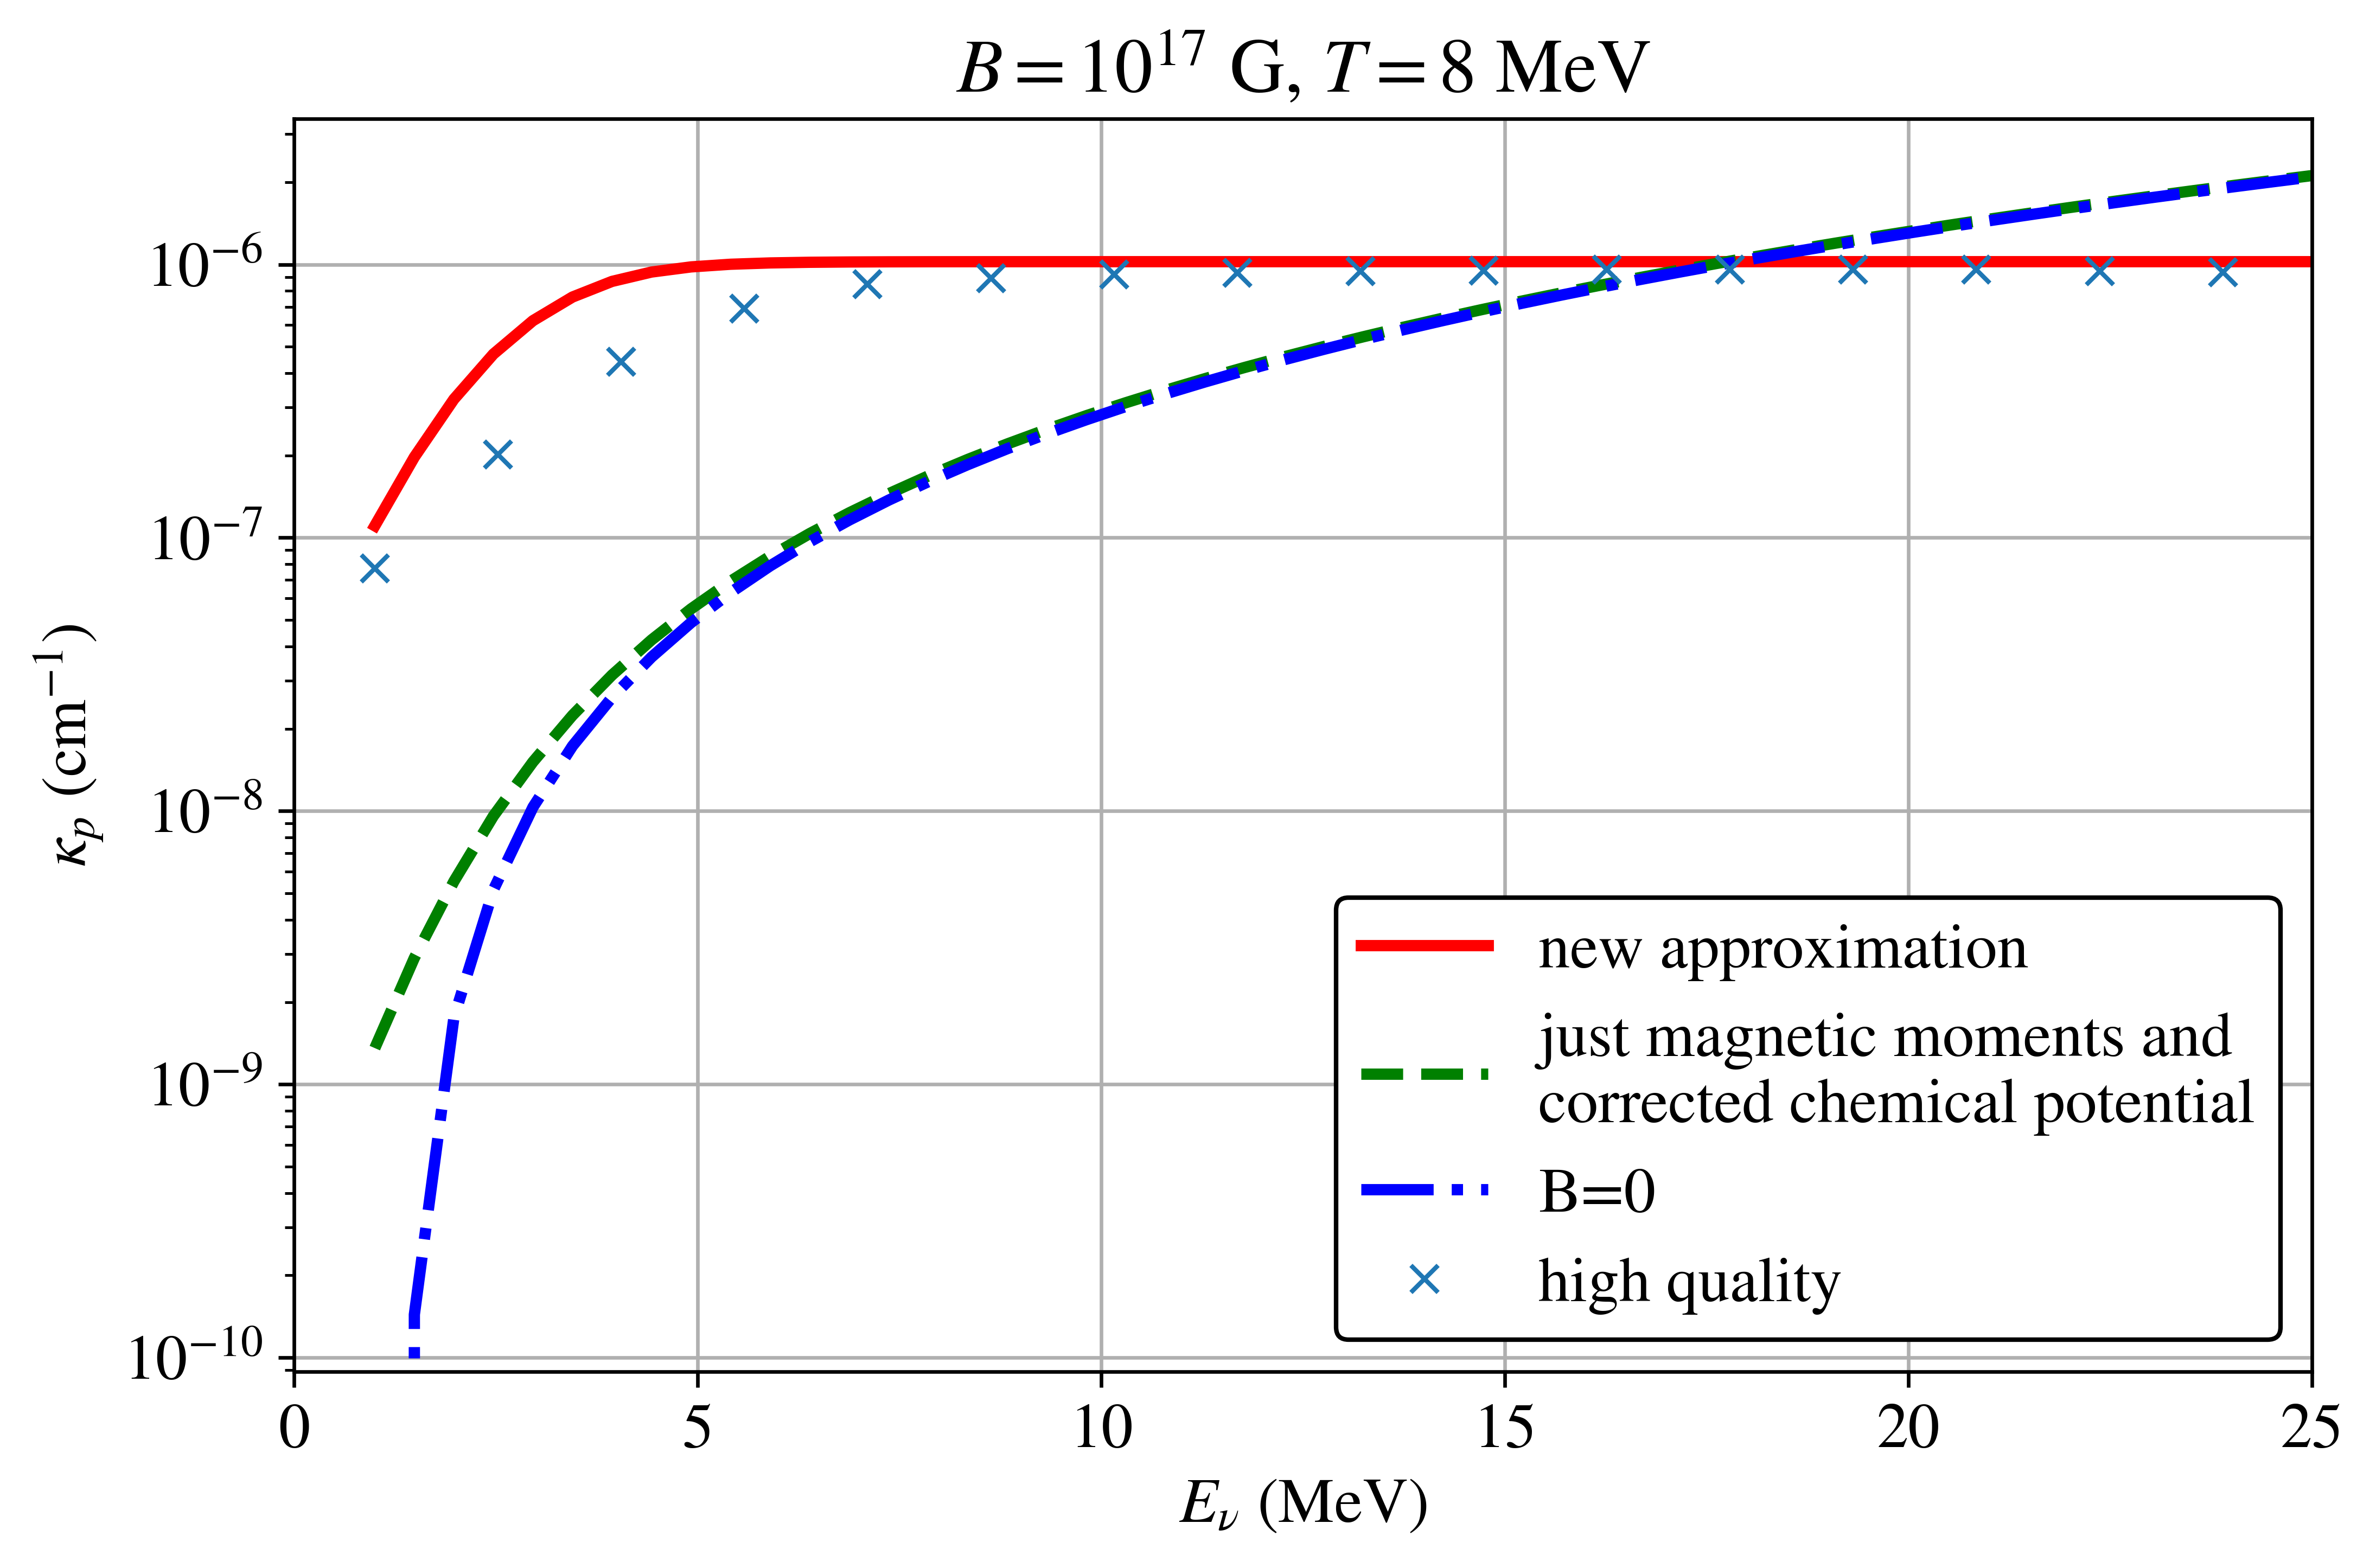

In [201]:
knuspace = linspace(1, 25, 50) / HBARC
knuspace_short = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (8, 5))

mue_low817 = mue_solver(0.25 * 0.16 * 10**-3, 1e17 * G_TO_FM, 8 / HBARC)
mue_low117 = mue_solver(0.25 * 0.16 * 10**-3, 1e17 * G_TO_FM, 1 / HBARC)

mue_high817 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 8 / HBARC)
mue_high117 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 1 / HBARC)

mue_low316 = mue_solver(0.25 * 0.16 * 10**-3, 5e16 * G_TO_FM, 8 / HBARC)
mue_low116 = mue_solver(0.25 * 0.16 * 10**-3, 5e16 * G_TO_FM, 1 / HBARC)

mue_high316 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 3 / HBARC)
mue_high116 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 1 / HBARC)

mue_low80 = mue_solver_zero(0.25 * 0.16 * 10**-3, 8 / HBARC)
mue_low30 = mue_solver_zero(0.25 * 0.16 * 10**-3, 3 / HBARC)
mue_low10 = mue_solver_zero(0.25 * 0.16 * 10**-3, 1 / HBARC)

mue_high80 = mue_solver_zero(0.1 * 0.16 * 10**-1, 8 / HBARC)
mue_high30 = mue_solver_zero(0.1 * 0.16 * 10**-1, 3 / HBARC)
mue_high10 = mue_solver_zero(0.1 * 0.16 * 10**-1, 1 / HBARC)

ebmt = 1e17 * G_TO_FM / (NUCLEON_MASS * 8 / HBARC)

ax_temp.plot(knuspace * HBARC, [proton_opacity([0.16 * 10**-3, 0.25], 1e17 * G_TO_FM, 8 / HBARC, mue_low817, knu, 0, False, False) * 10**13 for knu in knuspace], 'r-',
        knuspace * HBARC, [nup_opacity_low(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 8 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, [nup_opacity_zero(0.16 * 10**-3, 0.25, 8 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'b-.',
        knuspace_short * HBARC, sigma_p_b1e17_t3mev_lowdensity, 'x')
ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_p$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)

#ax_temp.set_ylim([0, 5e-6])
ax_temp.legend(['new approximation', 'just magnetic moments and \ncorrected chemical potential', 'B=0', 'high quality'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 8$ MeV')
ax_temp.set_xlim([0, 25])

In [ ]:
knuspace = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (8, 5))

mue_low817 = mue_solver(0.25 * 0.16 * 10**-3, 1e17 * G_TO_FM, 8 / HBARC)
mue_low117 = mue_solver(0.25 * 0.16 * 10**-3, 1e17 * G_TO_FM, 1 / HBARC)

mue_high817 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 8 / HBARC)
mue_high117 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 1 / HBARC)

mue_low316 = mue_solver(0.25 * 0.16 * 10**-3, 5e16 * G_TO_FM, 8 / HBARC)
mue_low116 = mue_solver(0.25 * 0.16 * 10**-3, 5e16 * G_TO_FM, 1 / HBARC)

mue_high316 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 3 / HBARC)
mue_high116 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 1 / HBARC)

mue_low80 = mue_solver_zero(0.25 * 0.16 * 10**-3, 8 / HBARC)
mue_low30 = mue_solver_zero(0.25 * 0.16 * 10**-3, 3 / HBARC)
mue_low10 = mue_solver_zero(0.25 * 0.16 * 10**-3, 1 / HBARC)

mue_high80 = mue_solver_zero(0.1 * 0.16 * 10**-1, 8 / HBARC)
mue_high30 = mue_solver_zero(0.1 * 0.16 * 10**-1, 3 / HBARC)
mue_high10 = mue_solver_zero(0.1 * 0.16 * 10**-1, 1 / HBARC)

ax_temp.plot(knuspace * HBARC, [proton_opacity([0.16 * 10**-3, 0.25], 1e17 * G_TO_FM, 8 / HBARC, mue_low817, knu, 0, True, False) * 10**13 for knu in knuspace], 'r-',
        knuspace * HBARC, [nun_opacity_low(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 8 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, [nun_opacity_zero(0.16 * 10**-3, 0.25, 8 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'b-.',
        knuspace * HBARC, sigma_n_b1e17_t3mev_lowdensity, 'x')
ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_n$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)
ax_temp.set_yscale('log')

ax_temp.set_ylim([1e-8, 1e-5])
ax_temp.legend(['new approximation', 'just magnetic moments and \ncorrected chemical potential', 'B=0', 'high quality'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 8$ MeV')
ax_temp.set_xlim([0, 25])

C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_ll = 10 * floor((t + mu)**2 / (2 * eb))
C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(lambda mu: log(ne) - log_electron_density(mu, eb, t), 5 / HBARC)[0]
C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:19: RuntimeWarning: overflow encountered in exp
  return fsolve(lambda mu: log(ne) - log(quad(lambda k: k**2 / (pi**2 * (np.exp((k - mu) / t) + 1)), 0, max((20 * t, 20 * (t + mu))))[0]), 20 / HBARC)[0]
C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:19: RuntimeWarning: overflow encountered in multiply


(0.0, 30.0)

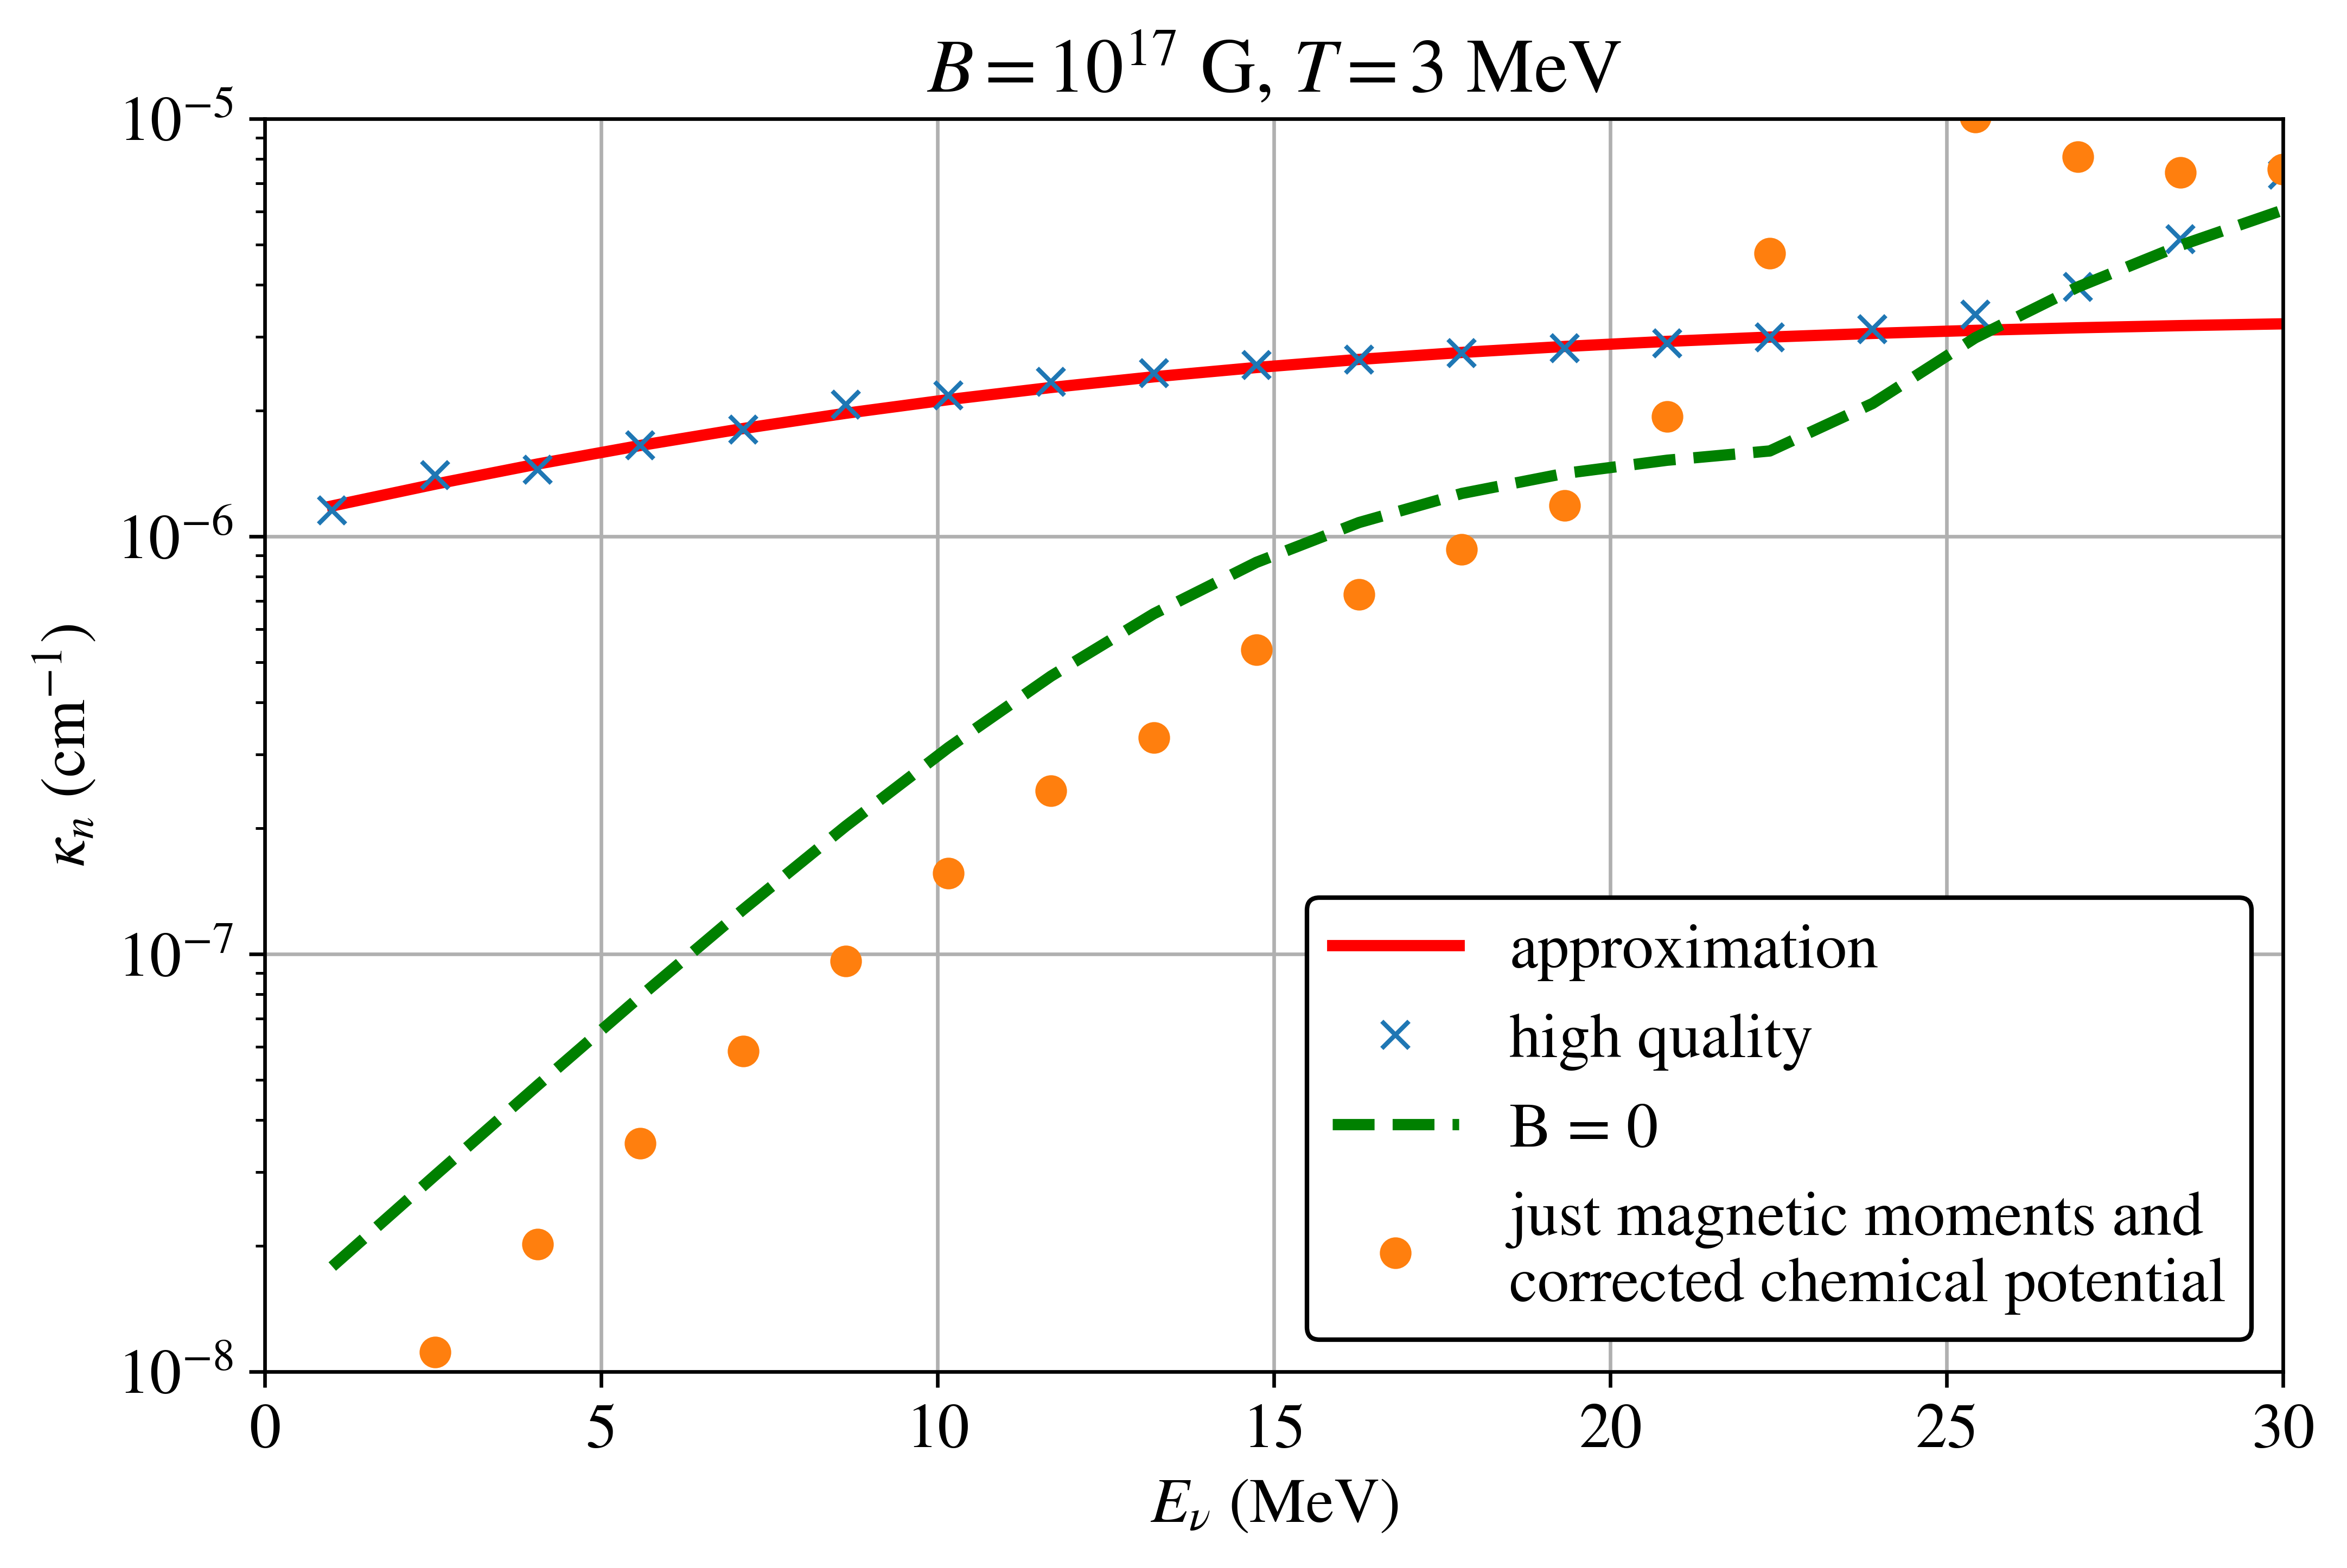

In [149]:
knuspace = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (8, 5))

mue_low817 = mue_solver(0.25 * 0.16 * 10**-3, 1e17 * G_TO_FM, 8 / HBARC)
mue_low117 = mue_solver(0.25 * 0.16 * 10**-3, 1e17 * G_TO_FM, 1 / HBARC)

mue_high817 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 8 / HBARC)
mue_high117 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 1 / HBARC)

mue_low316 = mue_solver(0.25 * 0.16 * 10**-3, 5e16 * G_TO_FM, 8 / HBARC)
mue_low116 = mue_solver(0.25 * 0.16 * 10**-3, 5e16 * G_TO_FM, 1 / HBARC)

mue_high316 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 3 / HBARC)
mue_high116 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 1 / HBARC)

mue_low80 = mue_solver_zero(0.25 * 0.16 * 10**-3, 8 / HBARC)
mue_low30 = mue_solver_zero(0.25 * 0.16 * 10**-3, 3 / HBARC)
mue_low10 = mue_solver_zero(0.25 * 0.16 * 10**-3, 1 / HBARC)

mue_high80 = mue_solver_zero(0.1 * 0.16 * 10**-1, 8 / HBARC)
mue_high30 = mue_solver_zero(0.1 * 0.16 * 10**-1, 3 / HBARC)
mue_high10 = mue_solver_zero(0.1 * 0.16 * 10**-1, 1 / HBARC)

ax_temp.plot(knuspace * HBARC, [neutron_opacity([0.16 * 10**-3, 0.25], 1e17 * G_TO_FM, 8 / HBARC, mue_low817, knu, 0, True, False) * 10**13 for knu in knuspace], 'r-',
        #knuspace * HBARC, [neutron_opacity([0.16 * 10**-3, 0.25], 1e17 * G_TO_FM, 8 / HBARC, mue_low817, knu, 0, False, False) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, sigma_n_b1e17_t3mev_lowdensity, 'x')
ax_temp.plot(knuspace * HBARC, [neutron_opacity([0.16 * 10**-3, 0.25], 5e16 * G_TO_FM, 3 / HBARC, mue_low316, knu, 0, False, False) * 10**13 for knu in knuspace], 'g--',
        #knuspace * HBARC, [neutron_opacity([0.16 * 10**-3, 0.25], 1e17 * G_TO_FM, 8 / HBARC, mue_low817, knu, 0, False, False) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, sigma_n_b5e16_t3mev_lowdensity, 'o')
#ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_n$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)
ax_temp.set_yscale('log')

ax_temp.set_ylim([1e-8, 1e-5])
ax_temp.legend(['approximation', 'high quality', 'B = 0', 'just magnetic moments and \ncorrected chemical potential'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 3$ MeV')
ax_temp.set_xlim([0, 30])

In [202]:
1e17 * G_TO_FM / (NUCLEON_MASS * 1 / HBARC)

0.6298322868564952

In [203]:
1e17 * G_TO_FM * HBARC**2

591.361

C:\Users\Kumamoto\AppData\Local\Temp/ipykernel_7408/1284276790.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_ll = 10 * floor((t + mu)**2 / (2 * eb))


(0.0, 30.0)

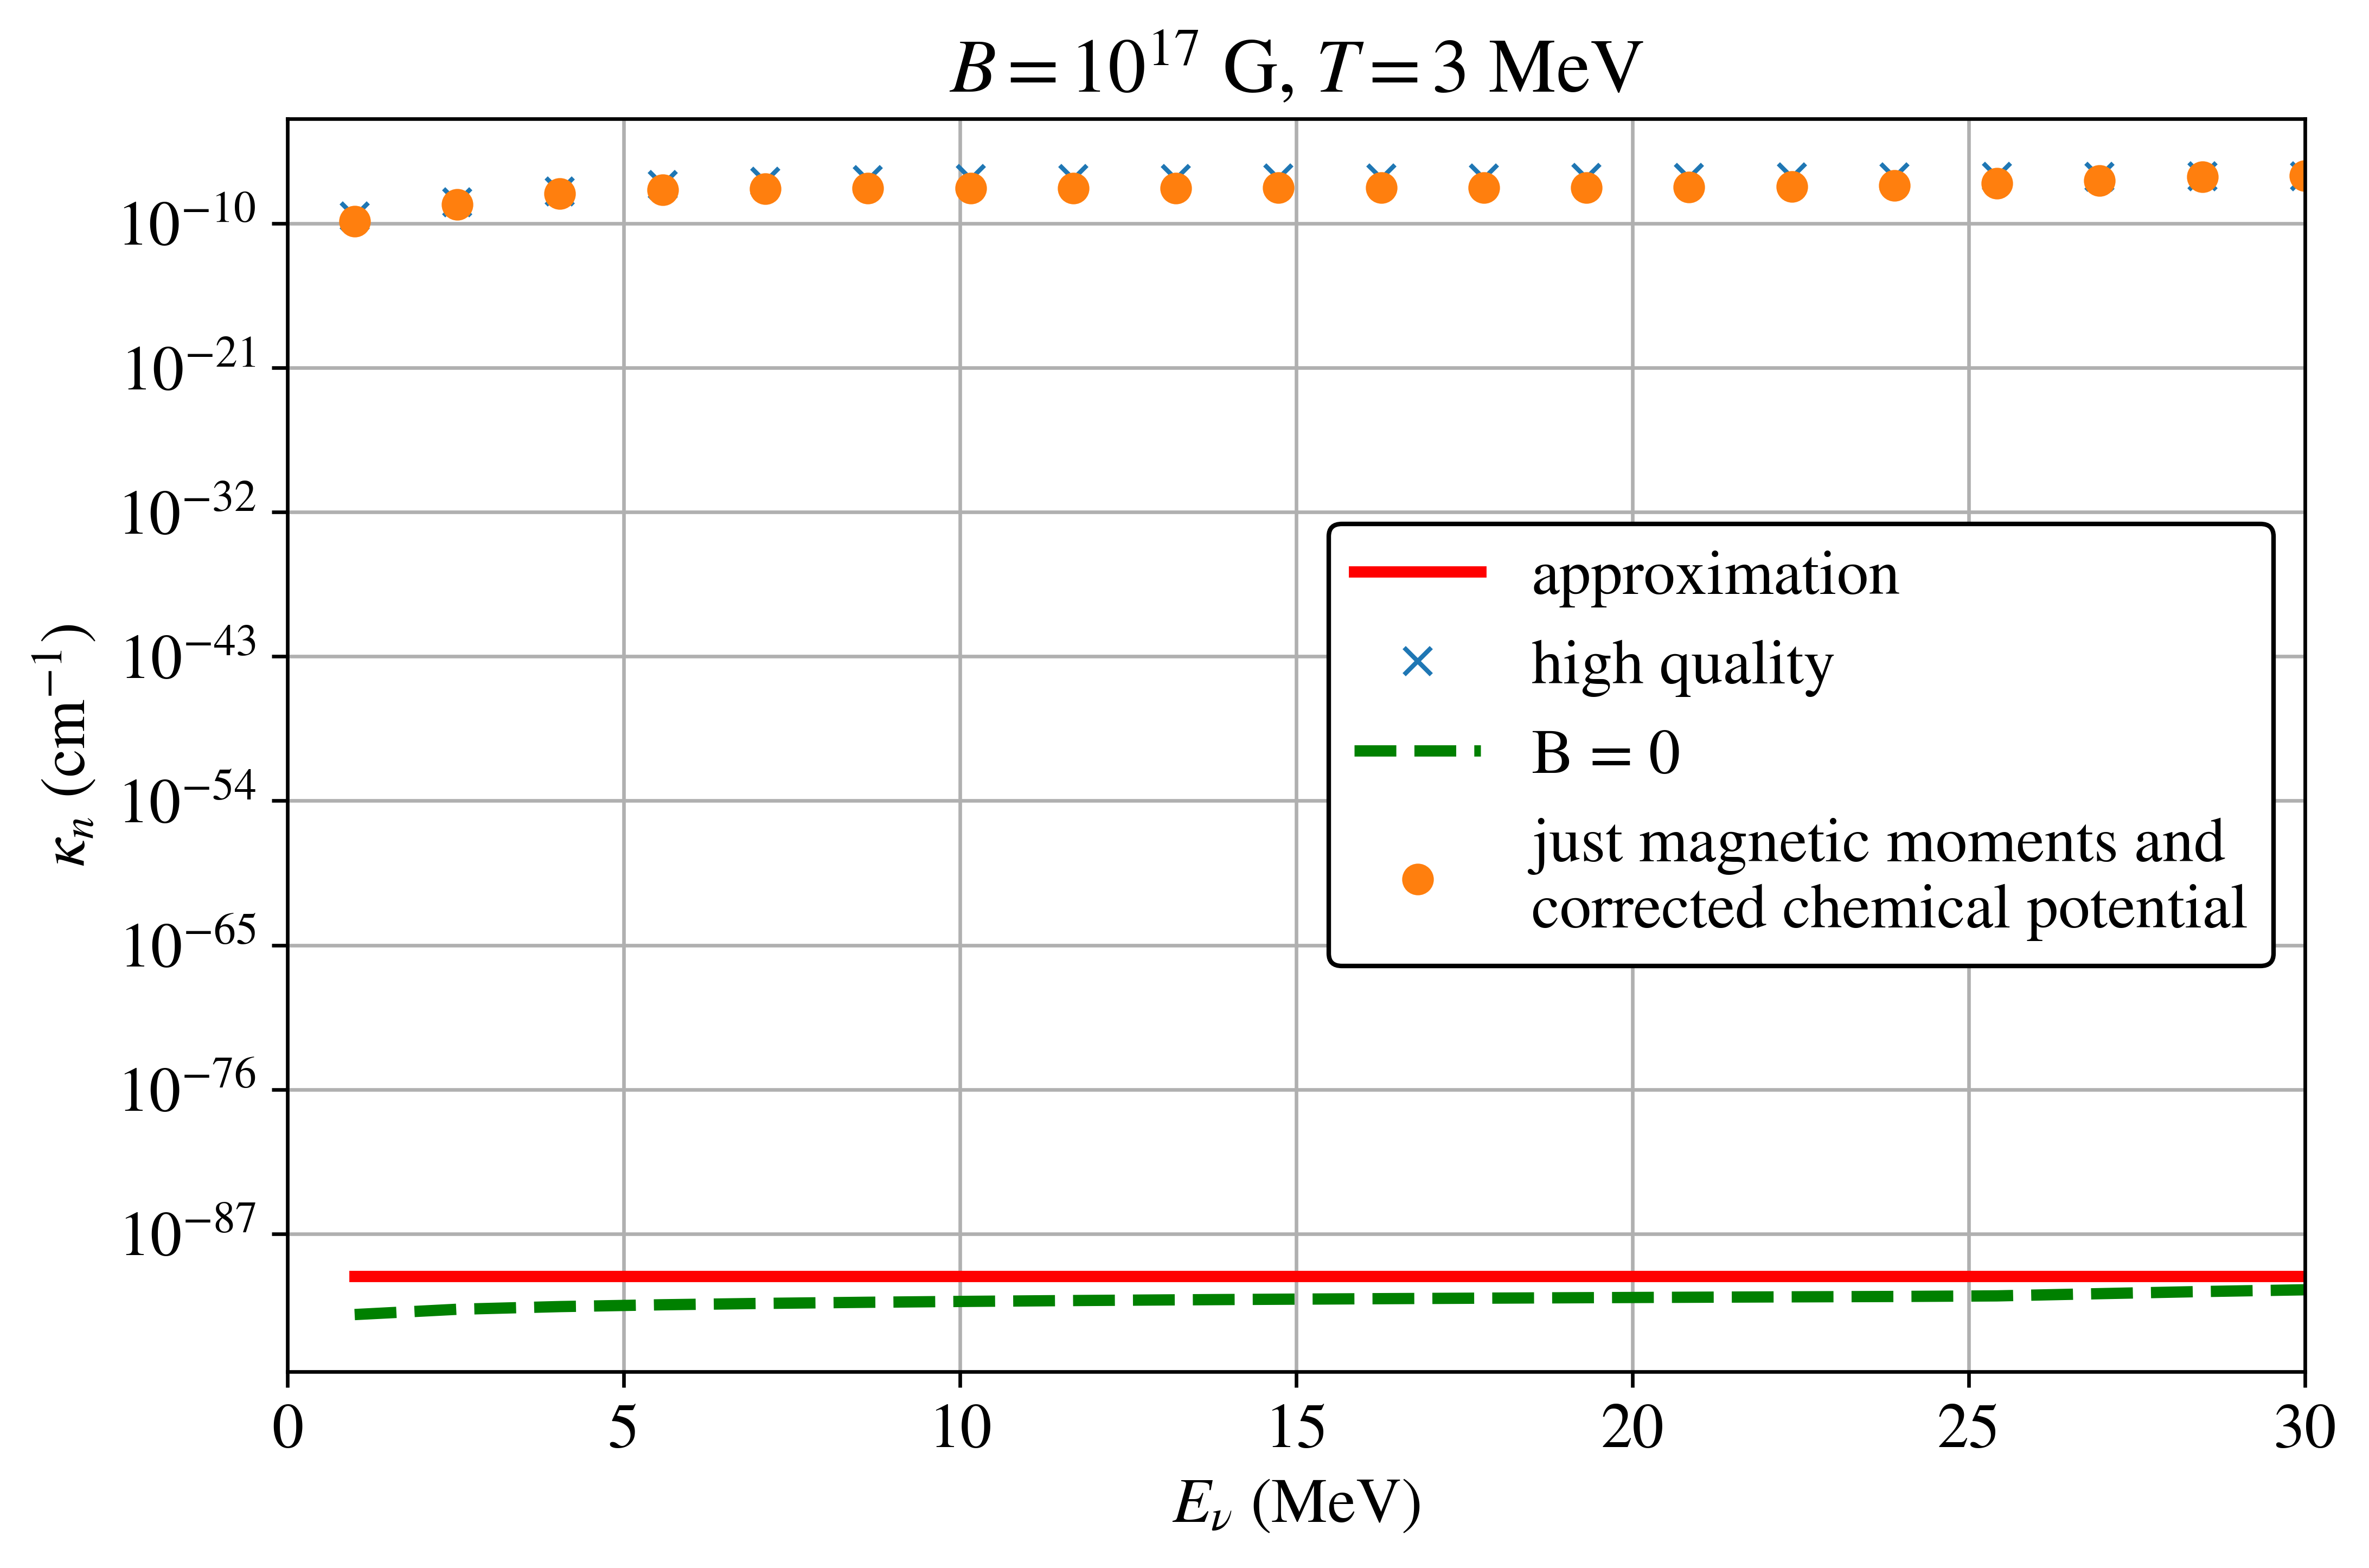

In [214]:
knuspace = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (8, 5))

mue_high817 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 8 / HBARC)
mue_high117 = mue_solver(0.1 * 0.16 * 10**-1, 1e17 * G_TO_FM, 1 / HBARC)
mue_high316 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 3 / HBARC)
mue_high116 = mue_solver(0.1 * 0.16 * 10**-1, 5e16 * G_TO_FM, 1 / HBARC)

ax_temp.plot(knuspace * HBARC, [proton_opacity([11.684, -0.997], 1e17 * G_TO_FM, 1 / HBARC, mue_high117, knu, 0, True, True) * 10**13 for knu in knuspace], 'r-',
        #knuspace * HBARC, [neutron_opacity([0.16 * 10**-3, 0.25], 1e17 * G_TO_FM, 8 / HBARC, mue_low817, knu, 0, False, False) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, sigma_p_b1e17_t1mev_highdensity, 'x')
ax_temp.plot(knuspace * HBARC, [proton_opacity([11.684, -0.97538], 5e16 * G_TO_FM, 1 / HBARC, mue_high116, knu, 0, False, True) * 10**13 for knu in knuspace], 'g--',
        #knuspace * HBARC, [neutron_opacity([0.16 * 10**-3, 0.25], 1e17 * G_TO_FM, 8 / HBARC, mue_low817, knu, 0, False, False) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, sigma_p_b5e16_t1mev_highdensity, 'o')
#ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_n$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)
ax_temp.set_yscale('log')

#ax_temp.set_ylim([1e-8, 1e-5])
ax_temp.legend(['approximation', 'high quality', 'B = 0', 'just magnetic moments and \ncorrected chemical potential'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 3$ MeV')
ax_temp.set_xlim([0, 30])

Text(0.5, 1.0, '$B = 10^{17}$ G, $T = 1$ MeV')

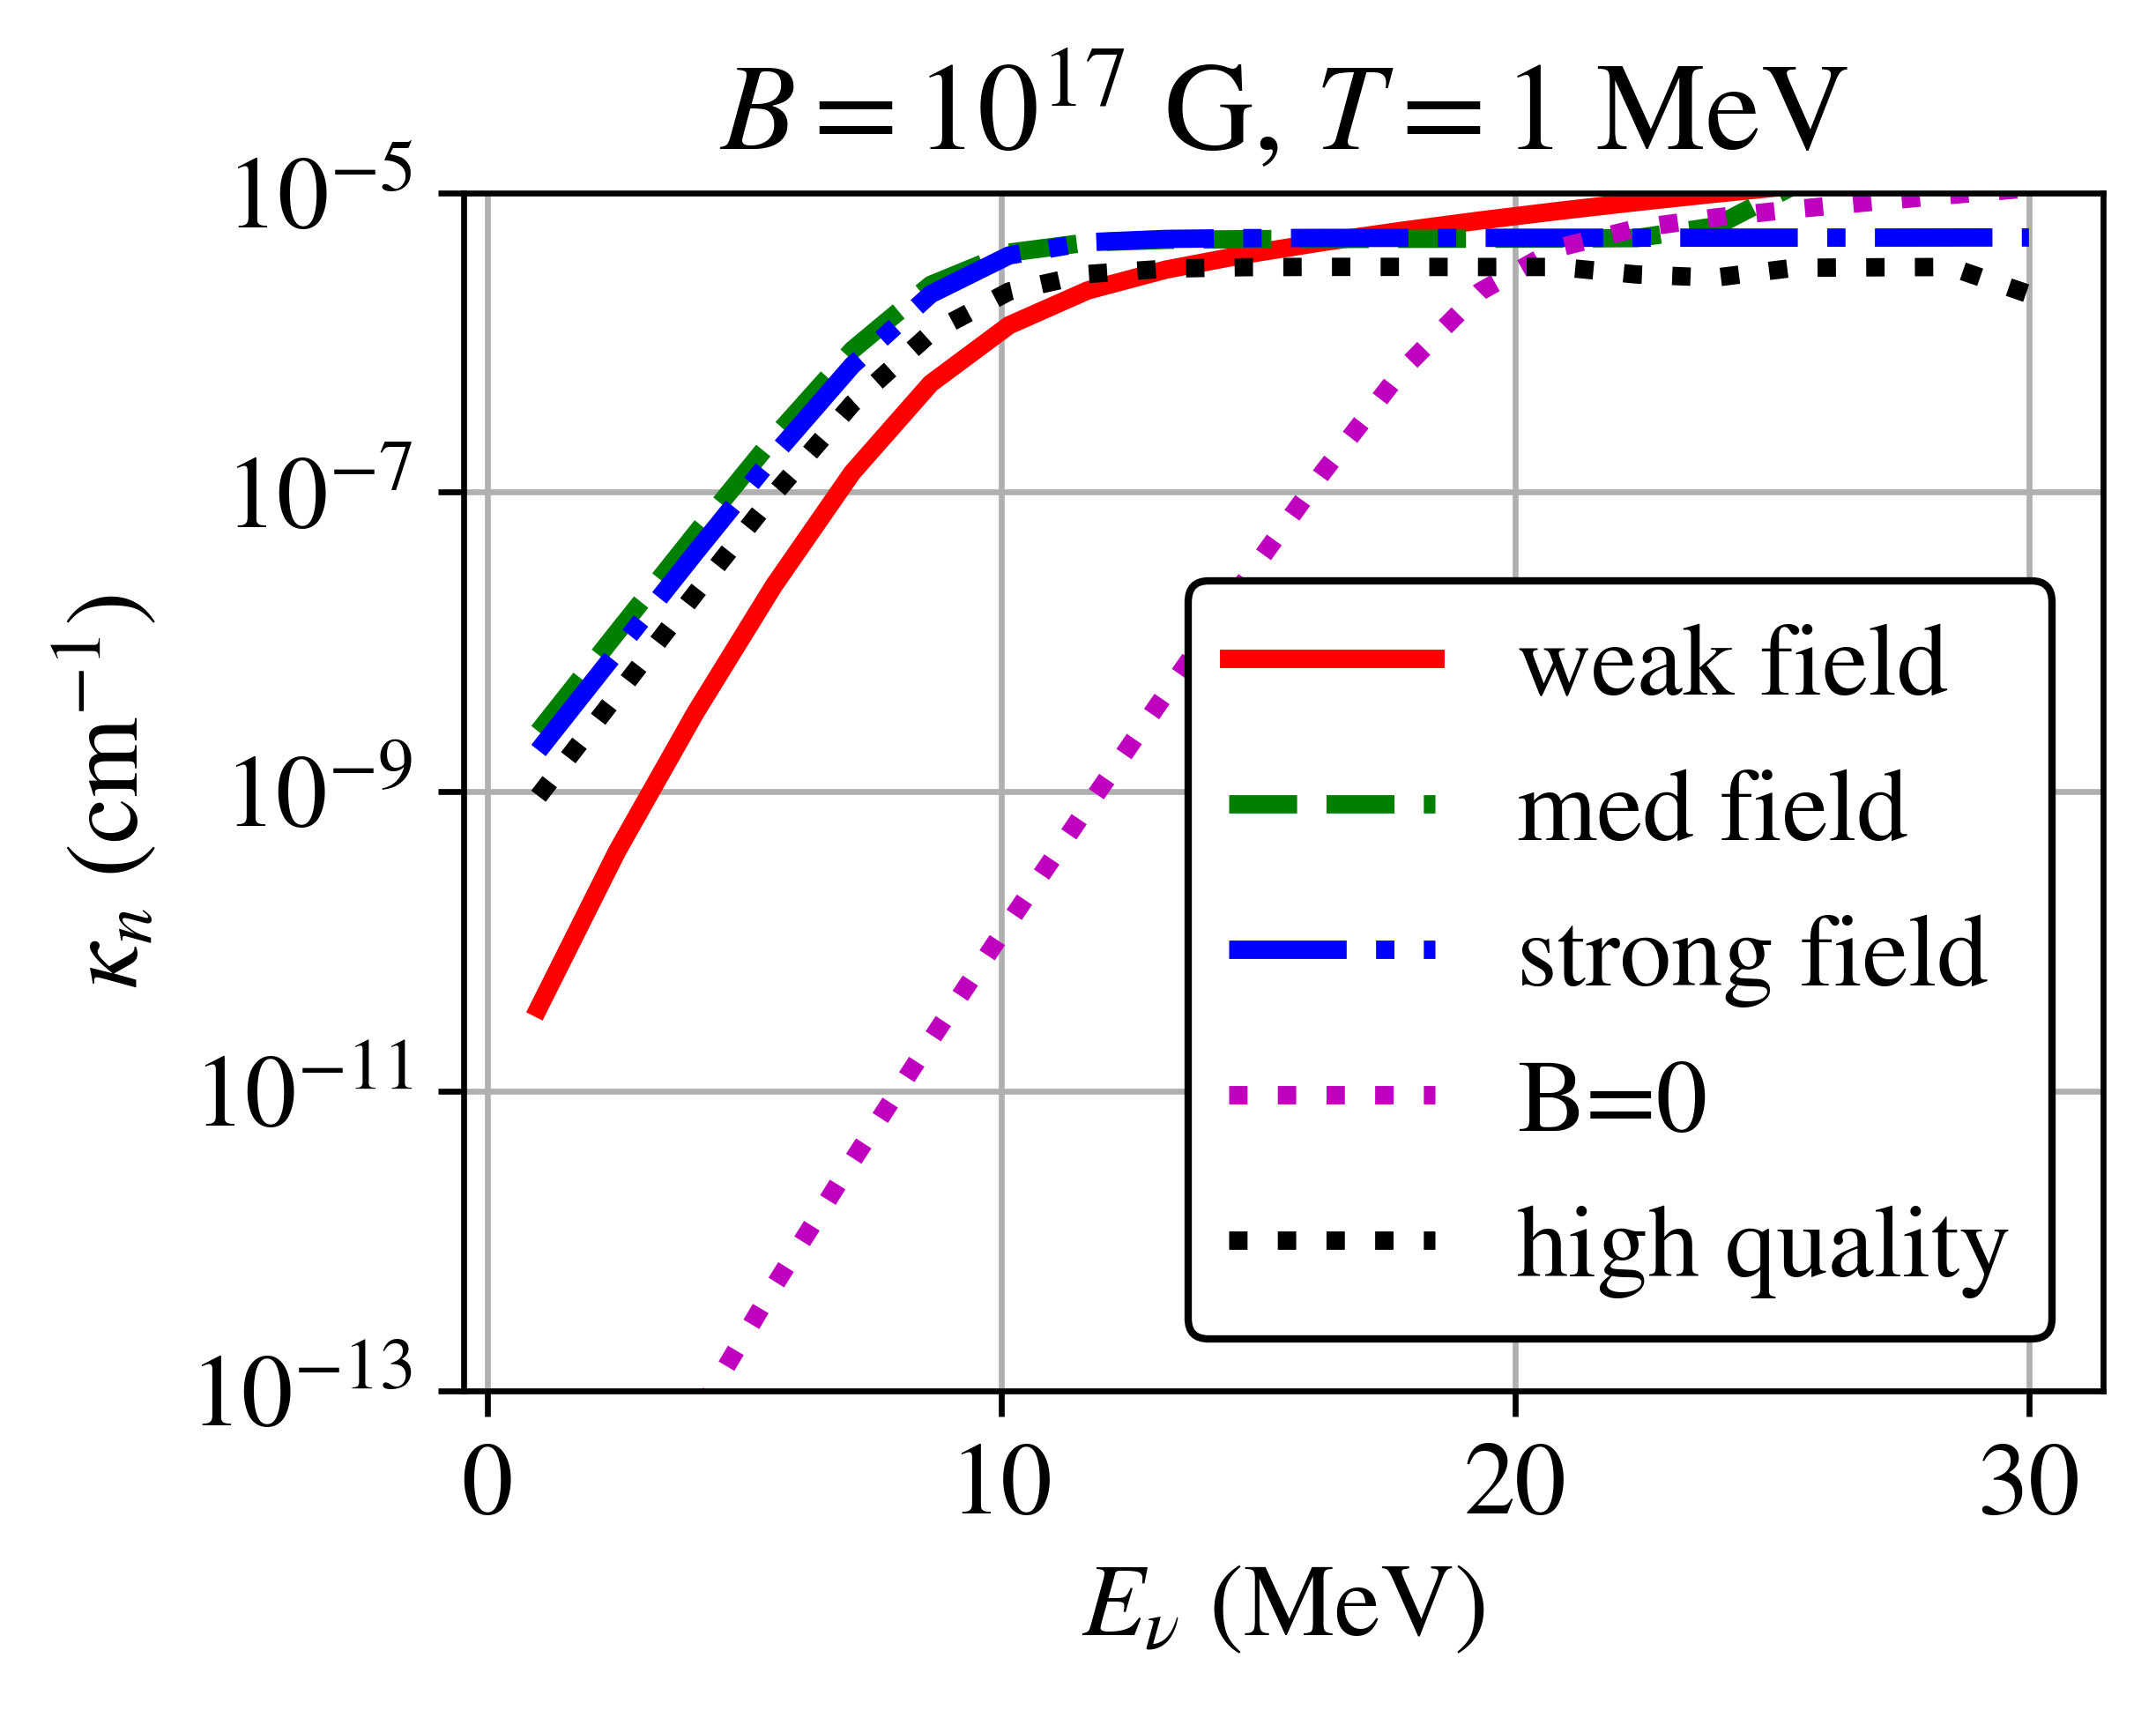

In [ ]:
knuspace = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (4, 3))

ax_temp.plot(knuspace * HBARC, [nun_opacity_low(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'r-',
        knuspace * HBARC, [nun_opacity_med(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, [nun_opacity_high(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'b-.',
        knuspace * HBARC, [nun_opacity_zero(0.16 * 10**-3, 0.25, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'm:',
        knuspace * HBARC, kappan_comp_1mev, 'k:')
ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_n$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)

ax_temp.set_ylim([1e-13, 1e-5])
ax_temp.legend(['weak field', 'med field', 'strong field', 'B=0', 'high quality'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 1$ MeV')

knuspace = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (8, 5))

ax_temp.plot(#knuspace * HBARC, [nun_opacity_low(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'r-',
        knuspace * HBARC, [nun_opacity_high(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'r-',
        #knuspace * HBARC, [nun_opacity_high(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'b-.',
        knuspace * HBARC, kappan_comp_3mev, 'g--',
        knuspace * HBARC, [nun_opacity_zero(0.16 * 10**-3, 0.25, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'b-.'
        )
ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_n$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)

ax_temp.set_ylim([1e-10, 1e-5])
ax_temp.legend(['approximation', 'high quality', 'zero field'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 1$ MeV')
ax_temp.set_xlim([0, 30])

In [76]:
%prun [nun_opacity_high(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in linspace(1 / HBARC, 50 / HBARC, 100)]

         5405223 function calls (5403021 primitive calls) in 17.504 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   466600    7.907    0.000    8.962    0.000 <ipython-input-2-39514f56976d>:22(fermi_dirac)
   466600    2.121    0.000   11.083    0.000 <ipython-input-2-39514f56976d>:35(nfd)
   233100    2.034    0.000   16.949    0.000 <ipython-input-55-01bf0ebd388f>:11(<lambda>)
   233100    1.554    0.000    1.554    0.000 <ipython-input-55-01bf0ebd388f>:1(electron_energy)
   233100    0.882    0.000    0.882    0.000 {method 'reduce' of 'numpy.ufunc' objects}
703303/701101    0.695    0.000    2.638    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   233100    0.428    0.000    1.486    0.000 fromnumeric.py:69(_wrapreduction)
     1100    0.398    0.000   17.347    0.016 {built-in method scipy.integrate._quadpack._qagse}
   466600    0.375    0.000    0.970    0.000 <__array_function__ i

0.005619103976164651